# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 150000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (150000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(126359, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

84.23933333333333

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(126357, 10)


1    106326
0     20031
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

I grew up reading these Sendak books, and watching the Really Rosie movie that incorporates them, and love them. My son loves them too. I do however, miss the hard cover version. The paperbacks seem kind of flimsy and it takes two hands to keep the pages open.
Its about time Spanish products started getting their due.. The most famous (rightly so) Spanish cheese, Manchego, is world class, and is really tough to beat.  Try some with some fig cake, or some quince paste, or drizzled with olive oil garnished with rosemary..  Serve with a fino sherry, manzanilla, or any number of red wines (depending on age of cheese), and you are guaranteed a winning combination..  Sliced, melted over a great burger, with a roasted red pepper and a hearty glass of earthy zinfandel = heavenly joy..  Cube and marinate in Spanish olive oil is also a treat... I have had no problems with iGourmet so far, so I can't comment on their customer service - all of my orders have been shipped quickly (1-3 business days

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

I grew up reading these Sendak books, and watching the Really Rosie movie that incorporates them, and love them. My son loves them too. I do however, miss the hard cover version. The paperbacks seem kind of flimsy and it takes two hands to keep the pages open.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

I grew up reading these Sendak books, and watching the Really Rosie movie that incorporates them, and love them. My son loves them too. I do however, miss the hard cover version. The paperbacks seem kind of flimsy and it takes two hands to keep the pages open.
Its about time Spanish products started getting their due.. The most famous (rightly so) Spanish cheese, Manchego, is world class, and is really tough to beat.  Try some with some fig cake, or some quince paste, or drizzled with olive oil garnished with rosemary..  Serve with a fino sherry, manzanilla, or any number of red wines (depending on age of cheese), and you are guaranteed a winning combination..  Sliced, melted over a great burger, with a roasted red pepper and a hearty glass of earthy zinfandel = heavenly joy..  Cube and marinate in Spanish olive oil is also a treat... I have had no problems with iGourmet so far, so I can't comment on their customer service - all of my orders have been shipped quickly (1-3 business days

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

I love this stuff.  I nuke a mug a milk until it is very hot, drop in 2 of the triangles, stir until the chocolate melts, then froth it with my Aerolatte.  Simple and tasty.


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

I grew up reading these Sendak books, and watching the Really Rosie movie that incorporates them, and love them. My son loves them too. I do however, miss the hard cover version. The paperbacks seem kind of flimsy and it takes two hands to keep the pages open.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

I love this stuff I nuke a mug a milk until it is very hot drop in 2 of the triangles stir until the chocolate melts then froth it with my Aerolatte Simple and tasty 


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 126357/126357 [00:51<00:00, 2451.95it/s]


In [23]:
preprocessed_reviews[1500]

'love stuff nuke mug milk hot drop triangles stir chocolate melts froth aerolatte simple tasty'

# [4] Featurization

## [4.1] BAG OF WORDS

In [25]:
from sklearn.model_selection import train_test_split


# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=Flase)# this is for time series split
X=np.asarray(preprocessed_reviews[:30000])
Y=final['Score'].values
print(X.shape," ",Y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, Y[:30000], test_size=0.33) # this is random splitting
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33) # this is random splitting

#print(X.shape,Y.shape)


(30000,)   (126357,)


In [26]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(X_train)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_countsXtrain = count_vect.transform(X_train)
final_countsXtest = count_vect.transform(X_test)
final_countsXcv = count_vect.transform(X_cv)
print("the shape of out text BOW vectorizer xtrain ",final_countsXtrain.get_shape())
print("the shape of out text BOW vectorizer xtest ",final_countsXtest.get_shape())
print("the shape of out text BOW vectorizer xcv ",final_countsXcv.get_shape())


#print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aaa', 'aaaa', 'aaah', 'aafco', 'aahs', 'aback', 'abandon', 'abandoned', 'abbey', 'abby']
the shape of out text BOW vectorizer xtrain  (13467, 22390)
the shape of out text BOW vectorizer xtest  (9900, 22390)
the shape of out text BOW vectorizer xcv  (6633, 22390)


In [27]:
count_vect = CountVectorizer(min_df=10, max_features=500) #in scikit-learn
count_vect.fit(X_train)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_countsXtraindense = count_vect.transform(X_train)
final_countsXtestdense = count_vect.transform(X_test)
final_countsXcvdense = count_vect.transform(X_cv)
print("the shape of out text BOW vectorizer xtrain ",final_countsXtraindense.get_shape())
print("the shape of out text BOW vectorizer xtest ",final_countsXtestdense.get_shape())
print("the shape of out text BOW vectorizer xcv ",final_countsXcvdense.get_shape())

some feature names  ['able', 'absolutely', 'actually', 'add', 'added', 'adding', 'ago', 'almost', 'already', 'also']
the shape of out text BOW vectorizer xtrain  (13467, 500)
the shape of out text BOW vectorizer xtest  (9900, 500)
the shape of out text BOW vectorizer xcv  (6633, 500)


## [4.3] TF-IDF

In [28]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(X_train)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idfXtrain = tf_idf_vect.transform(X_train)
final_tf_idfXtest = tf_idf_vect.transform(X_test)
final_tf_idfXcv = tf_idf_vect.transform(X_cv)
#print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer xtrain ",final_tf_idfXtrain.get_shape())
print("the shape of out text TFIDF vectorizer xtest ",final_tf_idfXtest.get_shape())
print("the shape of out text TFIDF vectorizer xcv ",final_tf_idfXcv.get_shape())
#print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])


some sample features(unique words in the corpus) ['ability', 'able', 'able buy', 'able eat', 'able enjoy', 'able find', 'able get', 'able make', 'able order', 'able purchase']
the shape of out text TFIDF vectorizer xtrain  (13467, 7897)
the shape of out text TFIDF vectorizer xtest  (9900, 7897)
the shape of out text TFIDF vectorizer xcv  (6633, 7897)


In [29]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10 ,max_features=500)
tf_idf_vect.fit(X_train)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idfXtraindense = tf_idf_vect.transform(X_train)
final_tf_idfXtestdense = tf_idf_vect.transform(X_test)
final_tf_idfXcvdense = tf_idf_vect.transform(X_cv)
#print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer xtrain ",final_tf_idfXtraindense.get_shape())
print("the shape of out text TFIDF vectorizer xtest ",final_tf_idfXtestdense.get_shape())
print("the shape of out text TFIDF vectorizer xcv ",final_tf_idfXcvdense.get_shape())
#print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['able', 'absolutely', 'actually', 'add', 'added', 'adding', 'ago', 'almost', 'already', 'also']
the shape of out text TFIDF vectorizer xtrain  (13467, 500)
the shape of out text TFIDF vectorizer xtest  (9900, 500)
the shape of out text TFIDF vectorizer xcv  (6633, 500)


## [4.4] Word2Vec

In [30]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentancextrain=[]
list_of_sentancextest=[]
list_of_sentancexcv=[]
for sentance in X_train:
    list_of_sentancextrain.append(sentance.split())
for sentance in X_test:
    list_of_sentancextest.append(sentance.split())
for sentance in X_cv:
    list_of_sentancexcv.append(sentance.split())

In [31]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentancextrain,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('good', 0.8905290365219116), ('excellent', 0.8094755411148071), ('amazing', 0.7418727874755859), ('wonderful', 0.7399888038635254), ('awesome', 0.7146968841552734), ('tasty', 0.7080962657928467), ('especially', 0.704258918762207), ('nice', 0.6967849731445312), ('well', 0.6953884959220886), ('love', 0.6863927245140076)]
[('uk', 0.9696457386016846), ('none', 0.9668293595314026), ('belgium', 0.966014564037323), ('archer', 0.9642293453216553), ('cousin', 0.9620208144187927), ('ive', 0.9599071145057678), ('host', 0.9576678276062012), ('name', 0.9571720957756042), ('remembered', 0.9568706154823303), ('junkie', 0.9566358327865601)]


In [32]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  6943
sample words  ['received', 'kit', 'expected', 'time', 'no', 'problems', 'ca', 'not', 'comment', 'growing', 'seeds', 'yet', 'weeks', 'started', 'well', 'every', 'one', 'children', 'love', 'toaster', 'pastries', 'hard', 'house', 'originally', 'purchased', 'local', 'health', 'food', 'pickiest', 'eater', 'obviously', 'going', 'pay', 'much', 'box', 'went', 'hunt', 'best', 'price', 'subscribe', 'save', 'amazon', 'get', 'free', 'shipping', 'means', 'even', 'go', 'store', 'deal']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [33]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectorsxtrain = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentancextrain): # for each review/sentence
    sent_vec = np.zeros(50)
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectorsxtrain.append(sent_vec)
sent_vectorsxtest = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentancextest): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectorsxtest.append(sent_vec)
sent_vectorsxcv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentancexcv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectorsxcv.append(sent_vec)
print(" w2v xtrain ",len(sent_vectorsxtrain)," ",len(sent_vectorsxtrain[0]))
print(" w2v xtest ",len(sent_vectorsxtest)," ",len(sent_vectorsxtest[0]))
print(" w2v xcv ",len(sent_vectorsxcv)," ",len(sent_vectorsxcv[0]))


100%|█████████████████████████████████████████████████████████████████████████████| 6633/6633 [00:09<00:00, 682.63it/s]


 w2v xtrain  13467   50
 w2v xtest  9900   50
 w2v xcv  6633   50


#### [4.4.1.2] TFIDF weighted W2v

In [34]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [35]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectorsxtrain = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentancextrain): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectorsxtrain.append(sent_vec)
    row += 1
tfidf_sent_vectorsxtest = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentancextest): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectorsxtest.append(sent_vec)
    row += 1
tfidf_sent_vectorsxcv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentancexcv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectorsxcv.append(sent_vec)
    row += 1
    

100%|██████████████████████████████████████████████████████████████████████████████| 6633/6633 [01:32<00:00, 71.75it/s]


# [5] : KNN

## [5.1] Applying KNN brute force

### [5.1.1] Applying KNN brute force on BOW,<font color='red'> SET 1</font>

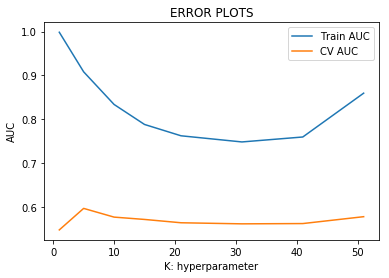

In [49]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler(with_mean=False)
x_train=scaler.fit_transform(final_countsXtrain)
x_test=scaler.fit_transform(final_countsXtest)
x_cv=scaler.fit_transform(final_countsXcv)

#print(final_countsXtrain.toarray().shape)
train_auc = []
cv_auc = []
K = [1, 5, 10, 15, 21, 31, 41, 51]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(x_train, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(x_train)[:,1]
    y_cv_pred =  neigh.predict_proba(x_cv)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()
    

TESTING KNN BRUTE FORCE ON BOW

5


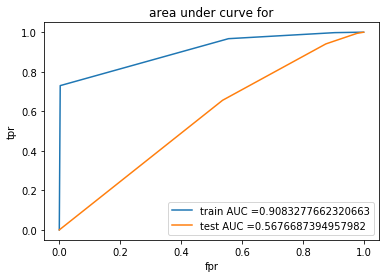

Train confusion matrix
[[  188  1791]
 [   23 11465]]
Test confusion matrix
[[  31 1369]
 [  49 8451]]


In [50]:
from sklearn.metrics import roc_curve, auc

best_k = K[cv_auc.index(max(cv_auc))]
print(best_k)
neigh = KNeighborsClassifier(n_neighbors=best_k)
neigh.fit(x_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(x_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(x_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("area under curve for")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, neigh.predict(x_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh.predict(x_test)))

### [5.1.2] Applying KNN brute force on TFIDF,<font color='red'> SET 2</font>

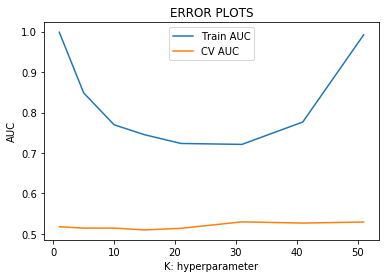

In [51]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler(with_mean=False)
x_train=scaler.fit_transform(final_tf_idfXtrain)
x_test=scaler.fit_transform(final_tf_idfXtest)
x_cv=scaler.fit_transform(final_tf_idfXcv)

#print(final_countsXtrain.toarray().shape)
train_auc = []
cv_auc = []
K = [1, 5, 10, 15, 21, 31, 41, 51]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(x_train, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(x_train)[:,1]
    y_cv_pred =  neigh.predict_proba(x_cv)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

TESTING KNN BRUTE FORCE ON TF-IDF


31


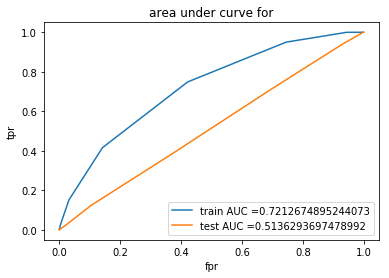

Train confusion matrix
[[    0  1979]
 [    0 11488]]
Test confusion matrix
[[   0 1400]
 [   0 8500]]


In [52]:
from sklearn.metrics import roc_curve, auc

best_k = K[cv_auc.index(max(cv_auc))]
print(best_k)
neigh = KNeighborsClassifier(n_neighbors=best_k)
neigh.fit(x_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(x_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(x_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("area under curve for")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, neigh.predict(x_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh.predict(x_test)))

### [5.1.3] Applying KNN brute force on AVG W2V,<font color='red'> SET 3</font>

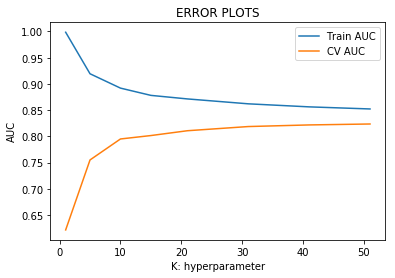

In [53]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler(with_mean=False)
x_train=scaler.fit_transform(sent_vectorsxtrain)
x_test=scaler.fit_transform(sent_vectorsxtest)
x_cv=scaler.fit_transform(sent_vectorsxcv)

#print(final_countsXtrain.toarray().shape)
train_auc = []
cv_auc = []
K = [1, 5, 10, 15, 21, 31, 41, 51]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(x_train, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(x_train)[:,1]
    y_cv_pred =  neigh.predict_proba(x_cv)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

TESTING KNN BRUTE FORCE ON AVG-W2VEC

51


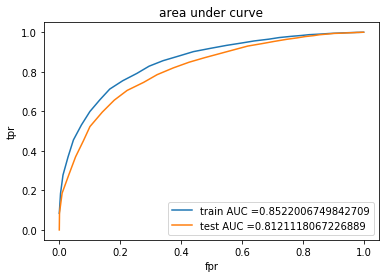

Train confusion matrix
[[  227  1752]
 [   75 11413]]
Test confusion matrix
[[ 139 1261]
 [  51 8449]]


In [54]:
from sklearn.metrics import roc_curve, auc

best_k = K[cv_auc.index(max(cv_auc))]
print(best_k)
neigh = KNeighborsClassifier(n_neighbors=best_k)
neigh.fit(x_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(x_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(x_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("area under curve")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, neigh.predict(x_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh.predict(x_test)))

### [5.1.4] Applying KNN brute force on TFIDF W2V,<font color='red'> SET 4</font>

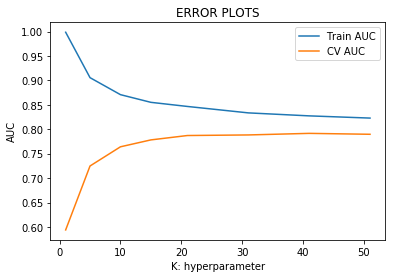

In [55]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler(with_mean=False)
x_train=scaler.fit_transform(tfidf_sent_vectorsxtrain)
x_test=scaler.fit_transform(tfidf_sent_vectorsxtest)
x_cv=scaler.fit_transform(tfidf_sent_vectorsxcv)

#print(final_countsXtrain.toarray().shape)
train_auc = []
cv_auc = []
K = [1, 5, 10, 15, 21, 31, 41, 51]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(x_train, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(x_train)[:,1]
    y_cv_pred =  neigh.predict_proba(x_cv)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

TESTING KNN BRUTE FORCE ON TFIDF-W2VEC

41


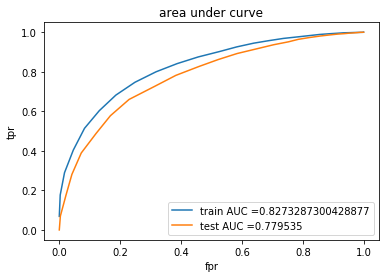

Train confusion matrix
[[  174  1805]
 [   60 11428]]
Test confusion matrix
[[  88 1312]
 [  59 8441]]


In [56]:
from sklearn.metrics import roc_curve, auc

best_k = K[cv_auc.index(max(cv_auc))]
print(best_k)
neigh = KNeighborsClassifier(n_neighbors=best_k)
neigh.fit(x_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(x_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(x_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("area under curve")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, neigh.predict(x_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh.predict(x_test)))

## [5.2] Applying KNN kd-tree

### [5.2.1] Applying KNN kd-tree on BOW,<font color='red'> SET 5</font>

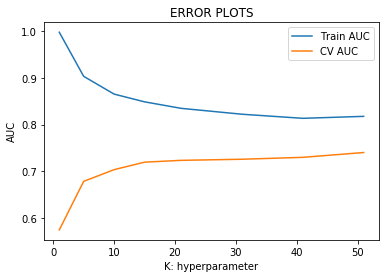

In [57]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")
scaler=StandardScaler(with_mean=False)
x_train=scaler.fit_transform(final_countsXtraindense)
x_test=scaler.fit_transform(final_countsXtestdense)
x_cv=scaler.fit_transform(final_countsXcvdense)

#print(final_countsXtrain.toarray().shape)
train_auc = []
cv_auc = []
K = [1, 5, 10, 15, 21, 31, 41, 51]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree')
    neigh.fit(x_train, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(x_train)[:,1]
    y_cv_pred =  neigh.predict_proba(x_cv)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

Testing KNN kd-tree on BOW, SET 5

51


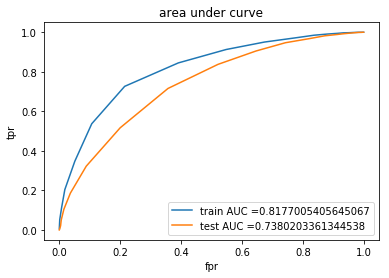

Train confusion matrix
[[    5  1974]
 [    0 11488]]
Test confusion matrix
[[   3 1397]
 [   1 8499]]


In [58]:
from sklearn.metrics import roc_curve, auc
import warnings
warnings.filterwarnings("ignore")
best_k = K[cv_auc.index(max(cv_auc))]
print(best_k)
neigh = KNeighborsClassifier(n_neighbors=best_k,algorithm='kd_tree')
neigh.fit(x_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(x_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(x_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("area under curve")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, neigh.predict(x_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh.predict(x_test)))

### [5.2.2] Applying KNN kd-tree on TFIDF,<font color='red'> SET 6</font>

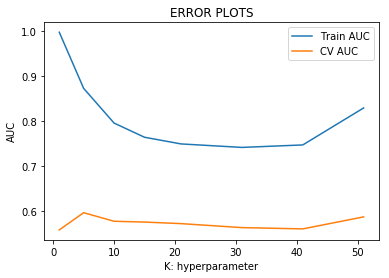

In [59]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")
scaler=StandardScaler(with_mean=False)
x_train=scaler.fit_transform(final_tf_idfXtraindense)
x_test=scaler.fit_transform(final_tf_idfXtestdense)
x_cv=scaler.fit_transform(final_tf_idfXcvdense)

#print(final_countsXtrain.toarray().shape)
train_auc = []
cv_auc = []
K = [1, 5, 10, 15, 21, 31, 41, 51]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree')
    neigh.fit(x_train, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(x_train)[:,1]
    y_cv_pred =  neigh.predict_proba(x_cv)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

Testing KNN kd-tree on TFIDF, SET 6


5


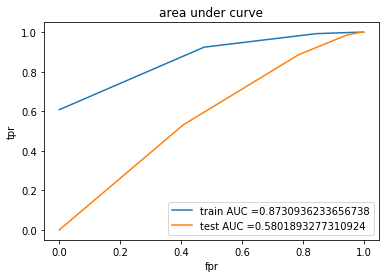

Train confusion matrix
[[  307  1672]
 [   81 11407]]
Test confusion matrix
[[  76 1324]
 [ 116 8384]]


In [60]:
from sklearn.metrics import roc_curve, auc
import warnings
warnings.filterwarnings("ignore")
best_k = K[cv_auc.index(max(cv_auc))]
print(best_k)
neigh = KNeighborsClassifier(n_neighbors=best_k,algorithm='kd_tree')
neigh.fit(x_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(x_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(x_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("area under curve")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, neigh.predict(x_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh.predict(x_test)))

### [5.2.3] Applying KNN kd-tree on AVG W2V,<font color='red'> SET 3</font>

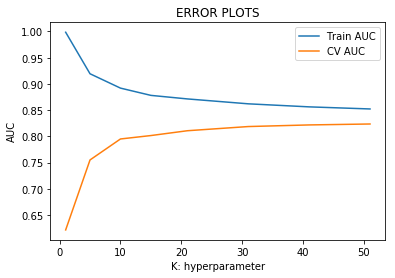

In [61]:

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")
scaler=StandardScaler(with_mean=False)
x_train=scaler.fit_transform(sent_vectorsxtrain)
x_test=scaler.fit_transform(sent_vectorsxtest)
x_cv=scaler.fit_transform(sent_vectorsxcv)

#print(final_countsXtrain.toarray().shape)
train_auc = []
cv_auc = []
K = [1, 5, 10, 15, 21, 31, 41, 51]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i , algorithm='kd_tree')
    neigh.fit(x_train, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(x_train)[:,1]
    y_cv_pred =  neigh.predict_proba(x_cv)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

Testing KNN kd-tree on AVG W2V, SET 3

51


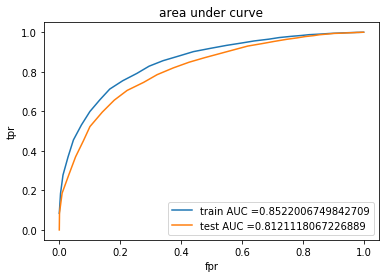

Train confusion matrix
[[  227  1752]
 [   75 11413]]
Test confusion matrix
[[ 139 1261]
 [  51 8449]]


In [63]:
from sklearn.metrics import roc_curve, auc
import warnings
warnings.filterwarnings("ignore")
best_k = K[cv_auc.index(max(cv_auc))]
print(best_k)
neigh = KNeighborsClassifier(n_neighbors=best_k,algorithm='kd_tree')
neigh.fit(x_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(x_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(x_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("area under curve")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, neigh.predict(x_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh.predict(x_test)))

### [5.2.4] Applying KNN kd-tree on TFIDF W2V,<font color='red'> SET 4</font>

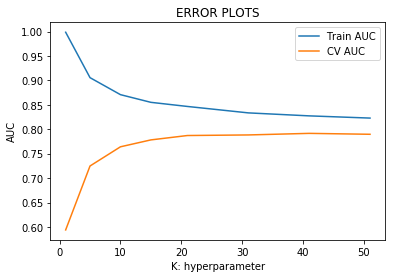

In [64]:

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")
scaler=StandardScaler(with_mean=False)
x_train=scaler.fit_transform(tfidf_sent_vectorsxtrain)
x_test=scaler.fit_transform(tfidf_sent_vectorsxtest)
x_cv=scaler.fit_transform(tfidf_sent_vectorsxcv)

#print(final_countsXtrain.toarray().shape)
train_auc = []
cv_auc = []
K = [1, 5, 10, 15, 21, 31, 41, 51]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree')
    neigh.fit(x_train, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(x_train)[:,1]
    y_cv_pred =  neigh.predict_proba(x_cv)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

Testing KNN kd-tree on TFIDF W2V, SET 4

41


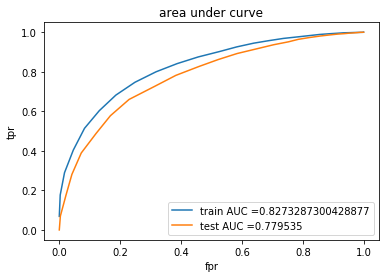

Train confusion matrix
[[  174  1805]
 [   60 11428]]
Test confusion matrix
[[  88 1312]
 [  59 8441]]


In [66]:
from sklearn.metrics import roc_curve, auc
import warnings
warnings.filterwarnings("ignore")
best_k = K[cv_auc.index(max(cv_auc))]
print(best_k)
neigh = KNeighborsClassifier(n_neighbors=best_k,algorithm='kd_tree')
neigh.fit(x_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(x_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(x_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("area under curve")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, neigh.predict(x_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh.predict(x_test)))

# [6] Conclusions

In [67]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Vectorizer", "Model", "Hyperparameter - k", "AUC"]

x.add_row(["BOW", "Brute Force KNN", 5,0.567])
x.add_row(["TFIDF", "Brute Force KNN",31,0.513])
x.add_row(["Avg- W2Vec", "Brute Force KNN", 51, 0.812])
x.add_row(["TFIDF- W2Vec","Brute Force KNN", 41, 0.729])
x.add_row(["BOW dense ", "KD- Tree knn", 51,0.738])
x.add_row(["TFIDF dense ","KD- Tree knn", 5, 0.580])
x.add_row(["Avg- W2Vec", "KD- Tree knn", 51,0.812])
x.add_row(["TFIDF- W2Vec", "KD- Tree knn", 41, 0.779])

print(x)

+--------------+-----------------+--------------------+-------+
|  Vectorizer  |      Model      | Hyperparameter - k |  AUC  |
+--------------+-----------------+--------------------+-------+
|     BOW      | Brute Force KNN |         5          | 0.567 |
|    TFIDF     | Brute Force KNN |         31         | 0.513 |
|  Avg- W2Vec  | Brute Force KNN |         51         | 0.812 |
| TFIDF- W2Vec | Brute Force KNN |         41         | 0.729 |
|  BOW dense   |   KD- Tree knn  |         51         | 0.738 |
| TFIDF dense  |   KD- Tree knn  |         5          |  0.58 |
|  Avg- W2Vec  |   KD- Tree knn  |         51         | 0.812 |
| TFIDF- W2Vec |   KD- Tree knn  |         41         | 0.779 |
+--------------+-----------------+--------------------+-------+
